!pip install nsepython

In [8]:
import pandas as pd 
import numpy as np 
import math
from datetime import datetime
from nsepython import *
import matplotlib.pyplot as plt


In [9]:
def binomial_option_pricing_model(S, K, T, N, r, std_dev, call_option=True):
    """
    Args:
        S            --> Current stock price
        K            --> Strike Price
        T            --> Total time period in years
        N            --> Number of steps in the binomial tree
        r            --> Risk-free interest rate (annualized)
        std_dev      --> Annualized standard deviation (volatility)
        call_option  --> True for call, False for put
    Output:
        Option current value
    """
    
    def payoff_fxn(S, K, call_option=True):
        return max(S - K, 0) if call_option else max(K - S, 0)
    
    def nCr(n, r):
        return math.comb(n, r)
    
    delta_t = T / N
    u = np.exp(std_dev * np.sqrt(delta_t))  # up factor
    d = 1 / u                                # down factor
    q = (np.exp(r * delta_t) - d) / (u - d) # risk-neutral probability
    
    values = []
    for i in range(N + 1):
        ST = S * (u ** i) * (d ** (N - i))  # price at node
        payoff = payoff_fxn(ST, K, call_option)
        prob = nCr(N, i) * (q ** i) * ((1 - q) ** (N - i))
        values.append(prob * payoff)
    
    option_price = sum(values) * np.exp(-r * T)
    return np.round(option_price, 2)

In [17]:
ticker = 'INFY'

# Get the option chain
option_chain = nse_optionchain_scrapper(ticker)
records = option_chain['records']['data']

# Get current stock price
S0 = option_chain['records']['underlyingValue']

# Filter only calls (you can also choose puts)
call_options = [item for item in records if 'CE' in item]

# Pick the ATM (closest strike to S0)
atm_option = min(call_options, key=lambda x: abs(x['CE']['strikePrice'] - S0))
K = atm_option['CE']['strikePrice']
market_price = atm_option['CE']['lastPrice']
implied_volatility = atm_option['CE']['impliedVolatility']# decimal like 0.20
expiry = atm_option['CE']['expiryDate']

# Compute time to maturity in years
expiry_date = datetime.datetime.strptime(expiry, '%d-%b-%Y')
print("Market Price :",market_price)
print("Implied Volatility :",implied_volatility)
print("Expiry Date :",expiry)




Market Price : 39
Implied Volatility : 23.24
Expiry Date : 28-Oct-2025


In [19]:
T = (expiry_date - datetime.datetime.now()).days / 365

# Risk-free rate (assume 6%)
r = 0.0625 ## can get exact value from indian government treasury bill

# Number of steps in binomial model
N = 1

# --- Calculate Binomial Price ---
binomial_price = binomial_option_pricing_model(S0, K, T, N, r, implied_volatility/100, call_option=True)

# --- Print Results ---
print(f"Stock Price: ₹{S0}")
print(f"Strike Price: ₹{K}")
print(f"Expiry Date: {expiry}")
print(f"Time to Maturity (Years): {T:.4f}")
print(f"Market Price: ₹{market_price}")
print(f"Binomial Model Price: ₹{binomial_price}")

Stock Price: ₹1439
Strike Price: ₹1440
Expiry Date: 28-Oct-2025
Time to Maturity (Years): 0.0658
Market Price: ₹39
Binomial Model Price: ₹45.21


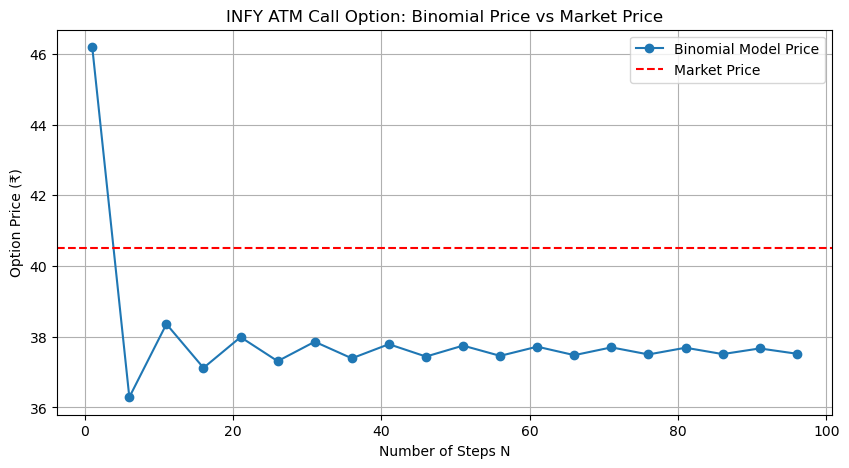

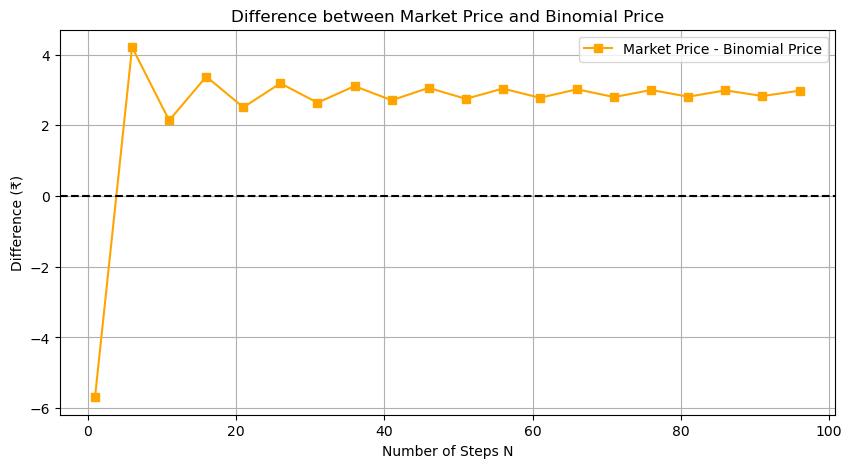

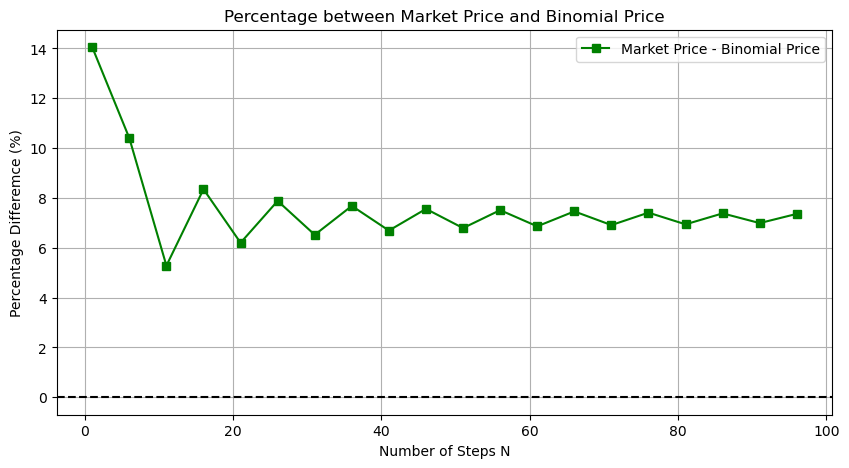

In [16]:

# List of N values to test
N_list = range(1,100,5)
binomial_prices = []
differences = []
per_diff = []
# Compute binomial price for each N and difference from market
for N in N_list:
    price = binomial_option_pricing_model(
        S=S0,
        K=K,
        T=T,
        N=N,
        r=r,
        std_dev=implied_volatility / 100,
        call_option=True
    )
    binomial_prices.append(price)
    differences.append(market_price - price)  # real difference, can be negative
    per_diff.append(np.round(abs(price - market_price)*100/market_price,2))

# Plot binomial price vs N
plt.figure(figsize=(10,5))
plt.plot(N_list, binomial_prices, marker='o', label='Binomial Model Price')
plt.axhline(y=market_price, color='r', linestyle='--', label='Market Price')
plt.xlabel('Number of Steps N')
plt.ylabel('Option Price (₹)')
plt.title('INFY ATM Call Option: Binomial Price vs Market Price')
plt.grid(True)
plt.legend()
plt.show()

# Plot difference from market
plt.figure(figsize=(10,5))
plt.plot(N_list, differences, marker='s', color='orange', label='Market Price - Binomial Price')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Number of Steps N')
plt.ylabel('Difference (₹)')
plt.title('Difference between Market Price and Binomial Price')
plt.grid(True)
plt.legend()
plt.show()

# Plot difference from market
plt.figure(figsize=(10,5))
plt.plot(N_list, per_diff, marker='s', color='Green', label='Market Price - Binomial Price')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Number of Steps N')
plt.ylabel('Percentage Differemce (%)')
plt.title('Percentage between Market Price and Binomial Price')
plt.grid(True)
plt.legend()
plt.show()

